In [35]:
import pandas as pd
import numpy as np
import json
from itertools import chain
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from copy import deepcopy

from preprocessing_utils import ScaleData, SplitData, n_lag_return, LogReturn2SimpleReturn
from sklearn.preprocessing import MinMaxScaler

In [2]:
def GetResultsFromJSON(ticker, fold, exp_dir):
    result_dir = f"{exp_dir}/fold{fold}/{ticker}/model_results.json"
    with open(result_dir, 'r') as f:
        results = json.load(f)
    return results

def FetchBestResults(results):
    best_idx = np.argmin(results['val_losses'])
    best_results = {key: value[best_idx] for key, value in results.items()}
    return best_results

In [3]:
stock_tickers = pd.read_csv('data/SP500_tickers_clean.csv', header=0).Ticker.unique()
stock_data = pd.read_csv('data/SP500_stock_prices_log_clean_3monthreturn.csv', index_col=0, parse_dates=True)
stock_data_sentiment = pd.read_csv('data/SP500_stock_prices_log_clean_3monthreturn_sentiment.csv', index_col=0, parse_dates=True)

In [4]:
TEST_SPLITS = ['2018-10-01', 
               '2019-01-01', 
               '2019-04-01', 
               '2019-07-01', 
               '2019-10-01']

In [110]:
# get the experiment names
exp_path = 'experiments/'
exp_s_path = 'experiments_sentiment/'
exp_names = os.listdir(exp_path)
exp_names.sort()

In [111]:
exp_names

['exp_cycl_1DH',
 'exp_cycl_1Dh',
 'exp_cycl_1dH',
 'exp_cycl_1dh',
 'exp_cycl_2DH',
 'exp_cycl_2Dh',
 'exp_cycl_2dH',
 'exp_cycl_2dh',
 'exp_plat_1DH',
 'exp_plat_1Dh',
 'exp_plat_1dH',
 'exp_plat_1dh',
 'exp_plat_2DH',
 'exp_plat_2Dh',
 'exp_plat_2dH',
 'exp_plat_2dh']

In [6]:
pred_index_df = pd.DataFrame(index=stock_data.index[stock_data.index >= TEST_SPLITS[4]].unique()).iloc[:63]
pred_index_df

""
Date
2019-10-01
2019-10-02
2019-10-03
2019-10-04
2019-10-07
...
2019-12-23
2019-12-24
2019-12-26


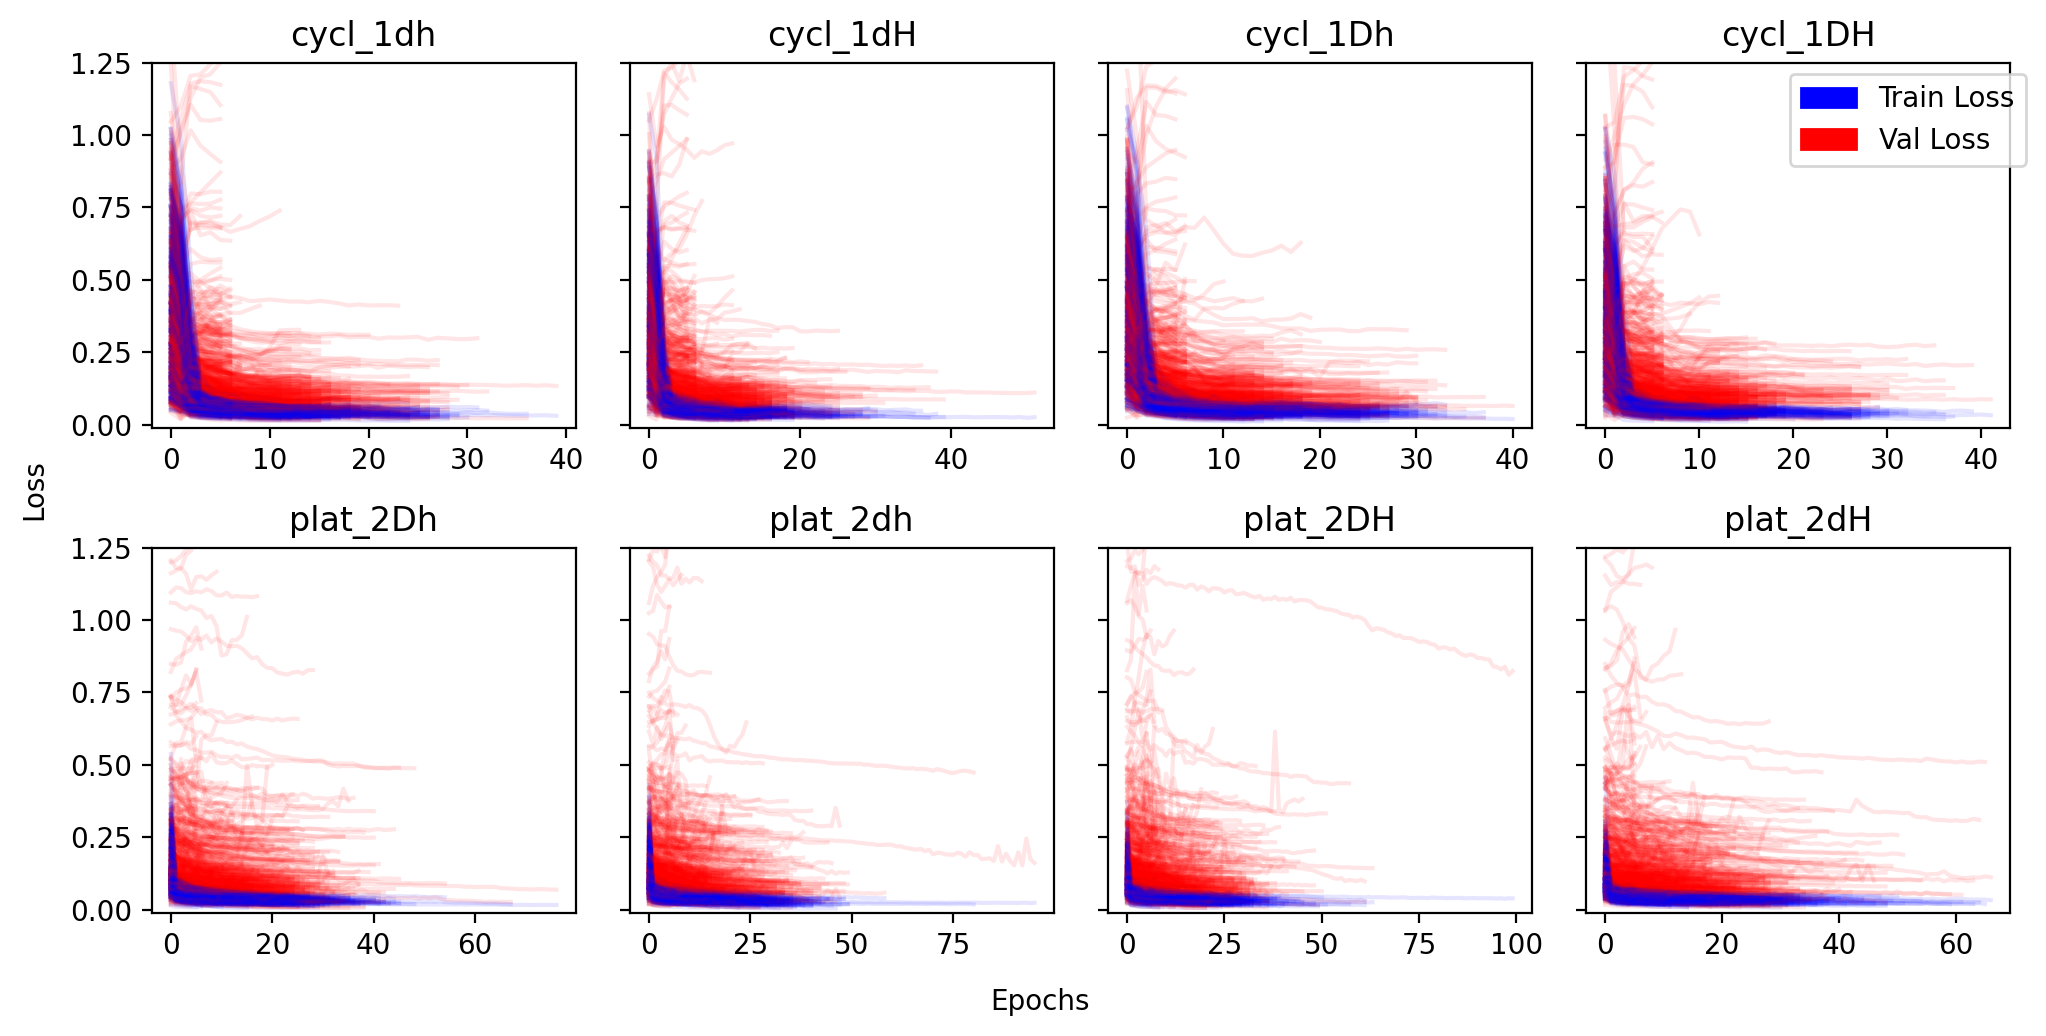

In [45]:
fig, axs = plt.subplots(2, 4, figsize=(10, 5), dpi=200)

for i, ax in enumerate(axs.flat):
    exp_name = exp_names[i]
    for ticker in stock_tickers:
        exp_dir = os.path.join(exp_path, exp_name)
        results = GetResultsFromJSON(ticker, 4, exp_dir)
        BestResults = FetchBestResults(results)

        ax.plot(results['train_losses'], color="blue", alpha=0.1)
        ax.plot(results['val_losses'], color="red", alpha=0.1)

        # Set the same y-axis and x-axis limits
        ax.set_ylim([-0.01, 1.25])
        # ax.set_xlim([0, 100])
        ax.set_title(exp_name[4:])

    # Remove x-axis label for top plots and y-axis label for right plots
    # if i < 6: ax.xaxis.set_tick_params(labelbottom=False)
    if i % 4 != 0: ax.yaxis.set_tick_params(labelleft=False)

# Legend
handles, labels = axs[0, 0].get_legend_handles_labels()

# axis labels
fig.text(0.5, -0.02, 'Epochs', ha='center')
fig.text(-0.01, 0.5, 'Loss', va='center', rotation='vertical')

train_patch = mpatches.Patch(color='blue', label='Train Loss')
val_patch = mpatches.Patch(color='red', label='Val Loss')
fig.legend(handles=[train_patch, val_patch], loc='upper right', bbox_to_anchor=(1, 0.93))

plt.tight_layout()
plt.show()


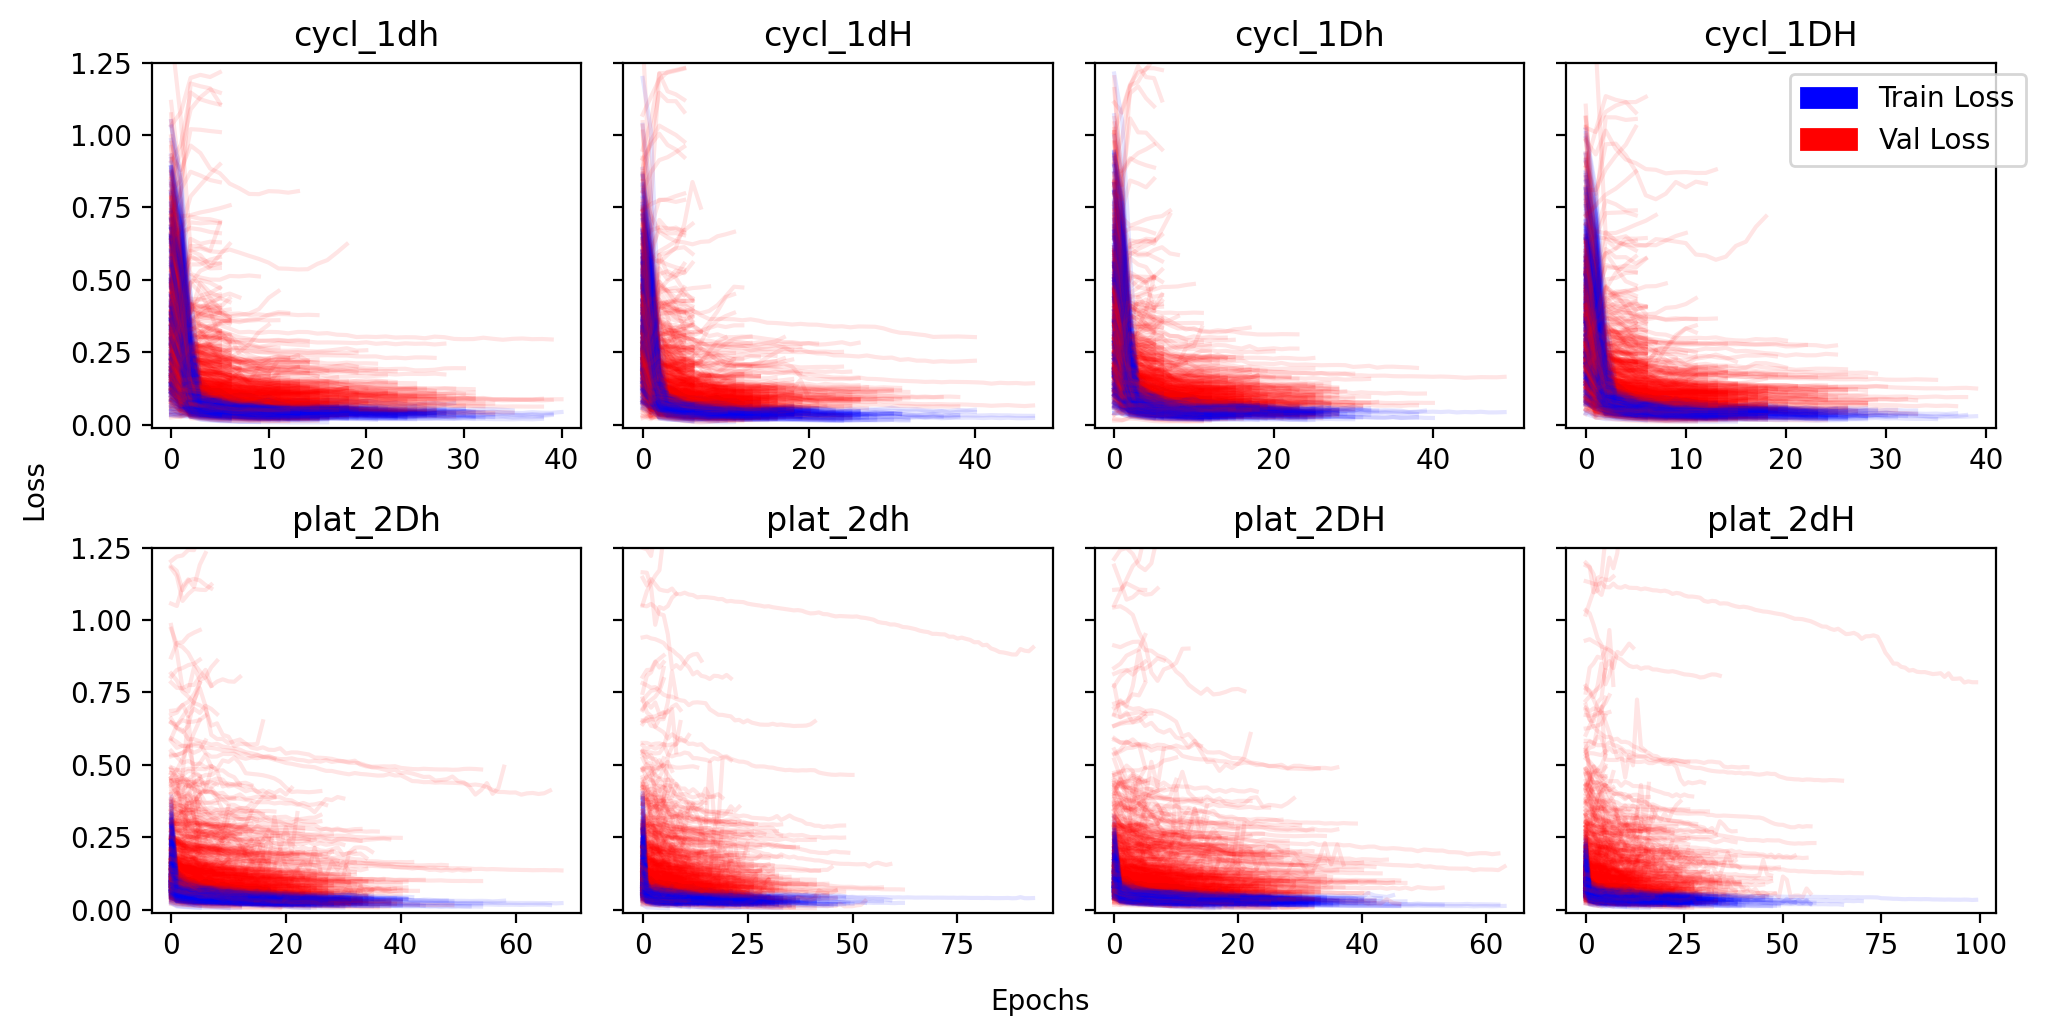

In [46]:
fig, axs = plt.subplots(2, 4, figsize=(10, 5), dpi=200)

for i, ax in enumerate(axs.flat):
    exp_name = exp_names[i]
    for ticker in stock_tickers:
        exp_dir = os.path.join(exp_s_path, exp_name)
        results = GetResultsFromJSON(ticker, 4, exp_dir)
        BestResults = FetchBestResults(results)

        ax.plot(results['train_losses'], color="blue", alpha=0.1)
        ax.plot(results['val_losses'], color="red", alpha=0.1)

        # Set the same y-axis and x-axis limits
        ax.set_ylim([-0.01, 1.25])
        # ax.set_xlim([0, 100])
        ax.set_title(exp_name[4:])

    # Remove x-axis label for top plots and y-axis label for right plots
    # if i < 6: ax.xaxis.set_tick_params(labelbottom=False)
    if i % 4 != 0: ax.yaxis.set_tick_params(labelleft=False)

# Legend
handles, labels = axs[0, 0].get_legend_handles_labels()

# axis labels
fig.text(0.5, -0.02, 'Epochs', ha='center')
fig.text(-0.01, 0.5, 'Loss', va='center', rotation='vertical')

train_patch = mpatches.Patch(color='blue', label='Train Loss')
val_patch = mpatches.Patch(color='red', label='Val Loss')
fig.legend(handles=[train_patch, val_patch], loc='upper right', bbox_to_anchor=(1, 0.93))

plt.tight_layout()
plt.show()


In [71]:
exp_train_losses = {}
exp_val_losses = {}

for exp_name in exp_names:

    best_ticker_train_losses = np.zeros(len(stock_tickers))
    best_ticker_val_losses = np.zeros(len(stock_tickers))
    for i, ticker in enumerate(stock_tickers):
        exp_dir = os.path.join(exp_path, exp_name)
        results = GetResultsFromJSON(ticker, 4, exp_dir)
        BestResults = FetchBestResults(results)

        best_ticker_train_losses[i] = BestResults['train_losses']
        best_ticker_val_losses[i] = BestResults['val_losses']

    exp_train_losses[exp_name[4:]] = best_ticker_train_losses.mean()
    exp_val_losses[exp_name[4:]] = best_ticker_val_losses.std()

# create horizontal bar chart
# each 

In [117]:
# create a dataframe
exp_losses_df = pd.DataFrame.from_dict(exp_train_losses, orient='index', columns=['train_loss'])
exp_losses_df['val_loss'] = exp_val_losses.values()
# sort by index
# exp_losses_df.sort_index(inplace=True, ascending=True)
exp_losses_df

,train_loss,val_loss
cycl_1DH,0.100635,0.129623
cycl_1Dh,0.088783,0.134088
cycl_1dH,0.097990,0.135508
cycl_1dh,0.091100,0.130579
cycl_2DH,0.117978,0.131363
cycl_2Dh,0.109366,0.131911
cycl_2dH,0.119336,0.131504
cycl_2dh,0.110973,0.130756
plat_1DH,0.041532,0.152499
plat_1Dh,0.040667,0.152633


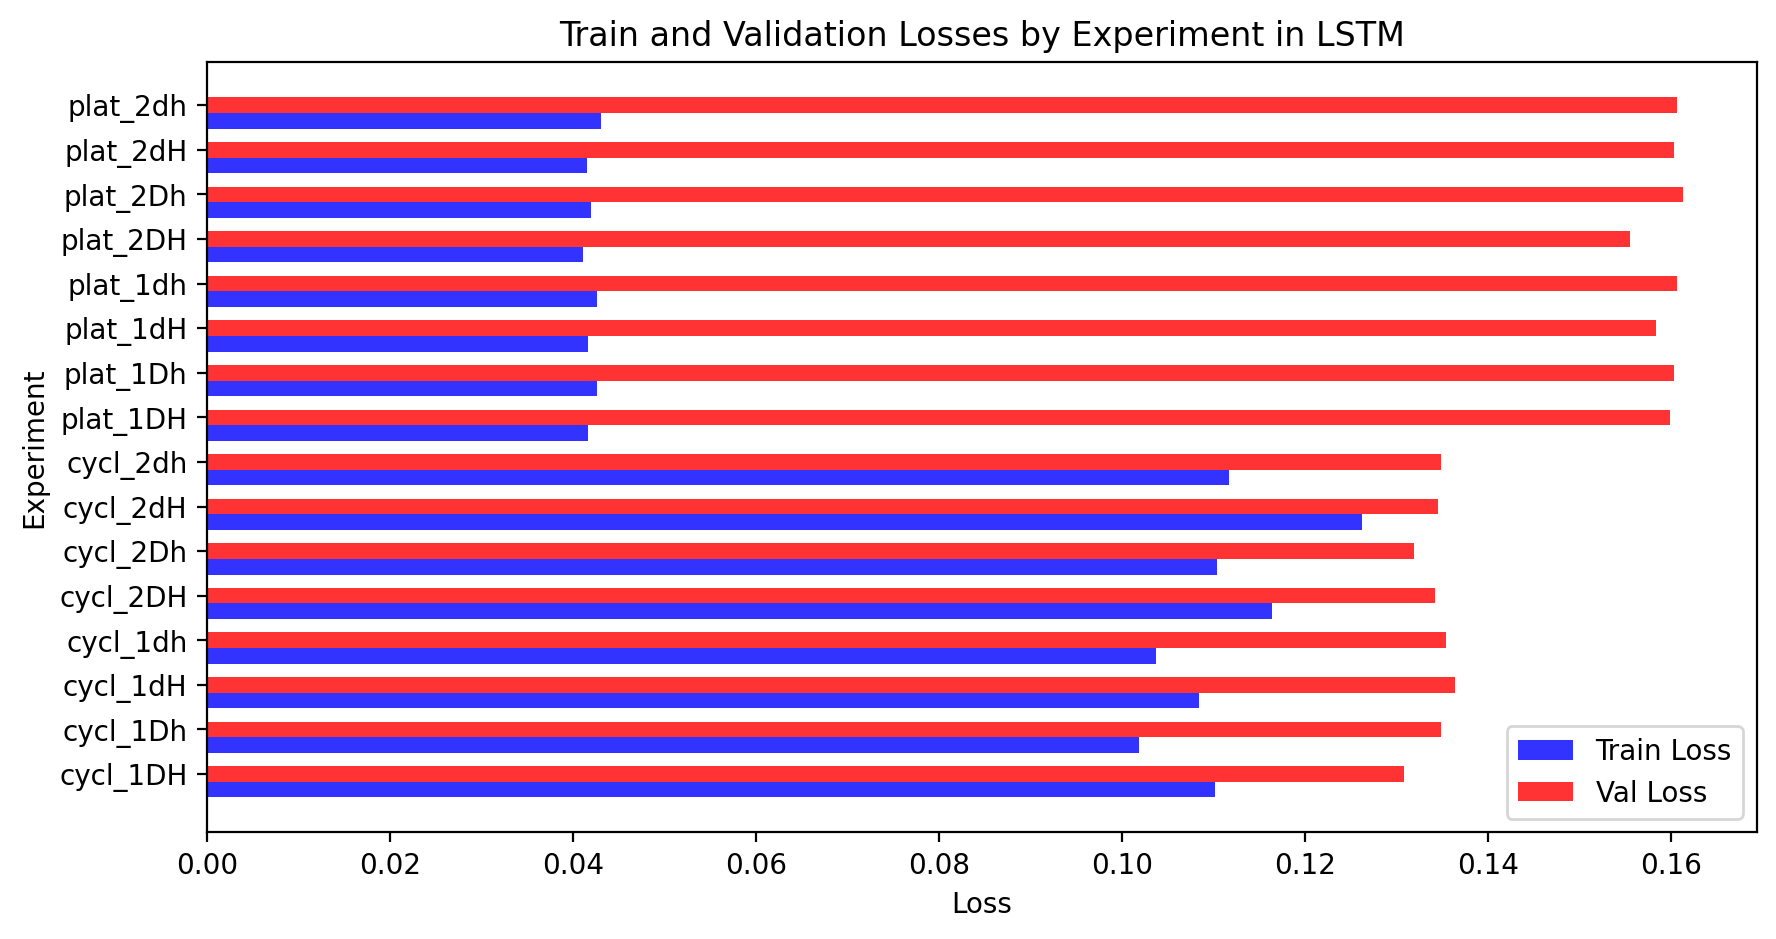

In [103]:
plt.figure(figsize=(10, 5), dpi=200)

# Create an array with the position of each bar along the x-axis
barWidth = 0.35
r1 = np.arange(len(exp_losses_df['train_loss']))
r2 = [x + barWidth for x in r1]

# Plot 'train_loss'
plt.barh(r1, exp_losses_df['train_loss'], color='blue', height=barWidth, label='Train Loss', alpha=0.8)

# Plot 'val_loss'
plt.barh(r2, exp_losses_df['val_loss'], color='red', height=barWidth, label='Val Loss', alpha=0.8)

# Adding xticks
plt.yticks([r + barWidth for r in range(len(exp_losses_df['train_loss']))], exp_losses_df.index)

plt.xlabel('Loss')  # Set the x-axis label
plt.ylabel('Experiment')  # Set the y-axis label
plt.title('Train and Validation Losses by Experiment in LSTM')  # Set the chart title
plt.legend(loc='lower right')  # Place the legend

plt.show()


In [104]:
exp_train_losses = {}
exp_val_losses = {}

for exp_name in exp_names:

    best_ticker_train_losses = np.zeros(len(stock_tickers))
    best_ticker_val_losses = np.zeros(len(stock_tickers))
    for i, ticker in enumerate(stock_tickers):
        exp_dir = os.path.join(exp_s_path, exp_name) #! change to exp_s_path
        results = GetResultsFromJSON(ticker, 4, exp_dir)
        BestResults = FetchBestResults(results)

        best_ticker_train_losses[i] = BestResults['train_losses']
        best_ticker_val_losses[i] = BestResults['val_losses']

    exp_train_losses[exp_name[4:]] = best_ticker_train_losses.mean()
    exp_val_losses[exp_name[4:]] = best_ticker_val_losses.std()

# create horizontal bar chart
# each 

In [105]:
# create a dataframe
exp_losses_df = pd.DataFrame.from_dict(exp_train_losses, orient='index', columns=['train_loss'])
exp_losses_df['val_loss'] = exp_val_losses.values()


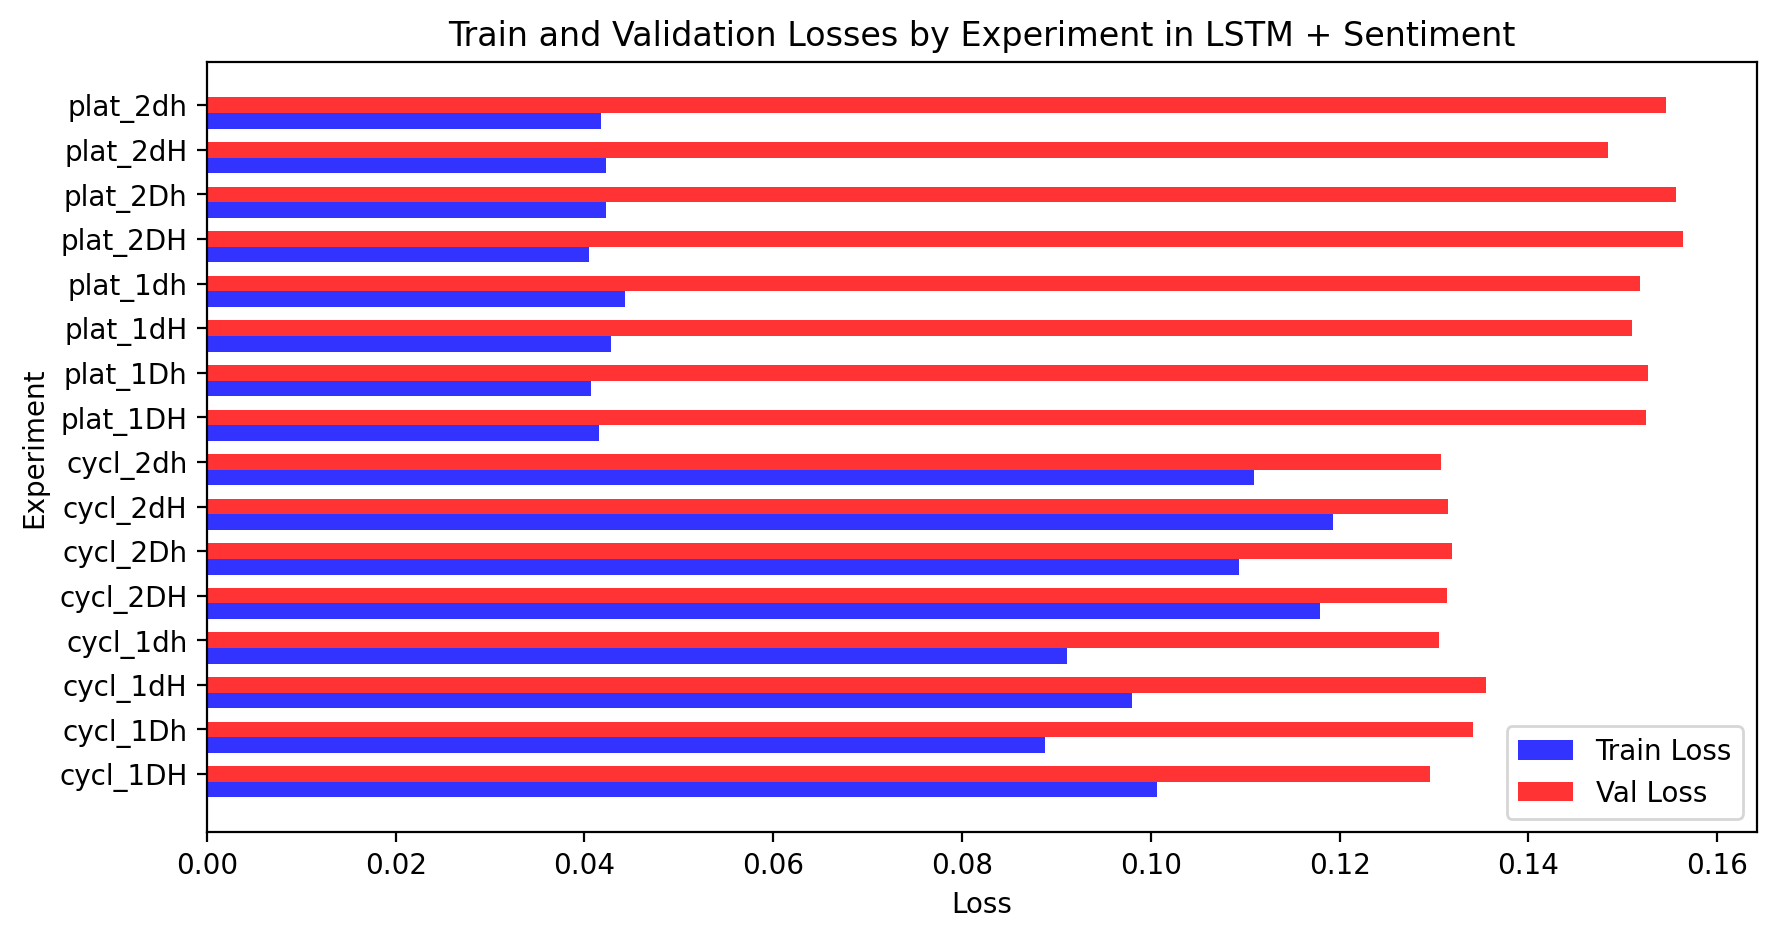

In [106]:
plt.figure(figsize=(10, 5), dpi=200)

# Create an array with the position of each bar along the x-axis
barWidth = 0.35
r1 = np.arange(len(exp_losses_df['train_loss']))
r2 = [x + barWidth for x in r1]

# Plot 'train_loss'
plt.barh(r1, exp_losses_df['train_loss'], color='blue', height=barWidth, label='Train Loss', alpha=0.8)

# Plot 'val_loss'
plt.barh(r2, exp_losses_df['val_loss'], color='red', height=barWidth, label='Val Loss', alpha=0.8)

# Adding xticks
plt.yticks([r + barWidth for r in range(len(exp_losses_df['train_loss']))], exp_losses_df.index)

plt.xlabel('Loss')  # Set the x-axis label
plt.ylabel('Experiment')  # Set the y-axis label
plt.title('Train and Validation Losses by Experiment in LSTM + Sentiment')  # Set the chart title
plt.legend(loc='lower right')  # Place the legend

plt.show()


In [118]:
exp_losses_df.index

Index(['cycl_1DH', 'cycl_1Dh', 'cycl_1dH', 'cycl_1dh', 'cycl_2DH', 'cycl_2Dh',
       'cycl_2dH', 'cycl_2dh', 'plat_1DH', 'plat_1Dh', 'plat_1dH', 'plat_1dh',
       'plat_2DH', 'plat_2Dh', 'plat_2dH', 'plat_2dh'],
      dtype='object')